<a href="https://colab.research.google.com/github/mfrdixon/alpha-RNN/blob/master/Alpha_RNNs_regime_switching_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:

import sys
sys.path.append('/content/drive/My Drive')

In [0]:

	
from numpy.random import seed
seed(1)
from tensorflow import set_random_seed
set_random_seed(1)

os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = ""
#import random as rn
#sd = 1 # Here sd means seed.
#np.random.seed(sd)
#rn.seed(sd)
#os.environ['PYTHONHASHSEED']=str(sd)

from keras import backend as K
config = tf.ConfigProto(intra_op_parallelism_threads=1,inter_op_parallelism_threads=1)
tf.set_random_seed(sd)
sess = tf.Session(graph=tf.get_default_graph(), config=config)
K.set_session(sess)

seed_value= 1
# 1. Set `PYTHONHASHSEED` environment variable at a fixed value
import os
os.environ['PYTHONHASHSEED']=str(seed_value)

# 2. Set `python` built-in pseudo-random generator at a fixed value
import random
random.seed(seed_value)

# 3. Set `numpy` pseudo-random generator at a fixed value
import numpy as np
np.random.seed(seed_value)

# 4. Set `tensorflow` pseudo-random generator at a fixed value
import tensorflow as tf
tf.set_random_seed(seed_value)

# 5. Configure a new global `tensorflow` session
from keras import backend as K
session_conf = tf.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)
sess = tf.Session(graph=tf.get_default_graph(), config=session_conf)
K.set_session(sess)


# To support both python 2 and python 3
from __future__ import division, print_function, unicode_literals

# Common imports
import numpy as np
import pandas as pd
from numpy import random
import os# Generate switching data set


# Imports for alpha_rnns 
from IPython import display
import tensorflow.compat.v1 as tf   
tf.disable_v2_behavior()
# Imports for stats

import matplotlib.pyplot as plt
import statsmodels.api as sm
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold
from sklearn.model_selection import TimeSeriesSplit
from keras import optimizers
from keras.callbacks import EarlyStopping
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM, GRU, SimpleRNN
from keras import optimizers
from keras.callbacks import EarlyStopping
from keras.regularizers import l1,l2
from keras import regularizers
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from keras.wrappers.scikit_learn import KerasClassifier, KerasRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import TimeSeriesSplit
#from alphaRNN import *
from keras.layers import Layer
from keras import backend as K
from keras import layers
import keras.layers
#from alphaRNN import *
from keras import *
from keras.legacy import interfaces

# To make this notebook's output stable across runs
def reset_graph(seed=42):
    tf.reset_default_graph()
    tf.set_random_seed(seed)
    np.random.seed(seed)

# To plot figures
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

# Where to save the figures
PROJECT_ROOT_DIR = "."

def save_fig(fig_id, tight_layout=True):
    path = os.path.join(PROJECT_ROOT_DIR, "images", fig_id + ".png")
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format='png', dpi=300)

In [0]:
def generate_vol_sample(length, sigma_0, n_steps, step_size, eps=0.01):
    sigma = np.array([0]*length, dtype='float64')
    sigma[0]=sigma_0
    mu = np.array([0]*length, dtype='float64')
    step_length=np.int(np.floor(np.float(length)/(2.0*n_steps)))
    
    for i in range(2*n_steps):
      mu[i*step_length:((i*step_length)+1)]=step_size*(-1)**i
     
    for i in range(1, length):
        sigma[i]=sigma[i-1] + mu[i] + eps*np.random.normal(0,1)
        
    return sigma   


In [0]:
def generate_vol_sample(length, sigma_0, n_steps, step_size, p, eps=0.01, shift=0):
    sigma = np.array([0]*length, dtype='float64')
    sigma[0]=sigma_0
    mu = np.array([0]*length, dtype='float64')
    phi = np.array([0]*length*p, dtype='float64').reshape(length,p)
    #phi2 = np.array([0]*length, dtype='float64')
    step_length=100 #np.int(np.floor(np.float(length)/(2.0*n_steps)))
    
    for i in range(2*n_steps):
      #mu[i*step_length:((i*step_length)+1)]=step_size #*(-1)**i
      mu[i*step_length:((i+1)*step_length)]= step_size*(-1)**i
      if i%2==0:  
        phi[i*step_length:((i+1)*step_length),:]= 0.02
        #phi2[i*step_length:((i+1)*step_length)]=1.0
      else:
        phi[i*step_length:((i+1)*step_length),:]=0.01
        #phi2[i*step_length:((i+1)*step_length)]=0.5
    for i in range(p, length):
        sigma[i]= mu[i-1] + np.random.normal(0,eps)
        for j in range(p):
          sigma[i]+=phi[i-1,j]*sigma[i-j]  
        
    return (sigma+shift)

In [0]:
p = 30 # the number of lags (in both the data and the models)
vols=generate_vol_sample(2000, 0.25, 15, 0.1, p, 1e-4, 0.13)[p:]

In [0]:
df = pd.DataFrame(vols, columns=['vol'])

In [101]:
use_features = ['vol'] 
target = 'vol'
n_steps = 30 # number of lags to include in the model

train_weight = 0.8
split = int(len(df)*train_weight)

df_train = df[use_features].iloc[:split]
print(df_train)
df_test = df[use_features].iloc[split:]

           vol
0     0.232166
1     0.233981
2     0.236069
3     0.238135
4     0.240495
...        ...
1571  0.149793
1572  0.153066
1573  0.156344
1574  0.159496
1575  0.163017

[1576 rows x 1 columns]


In [0]:
def get_lagged_features(value, n_steps):
    lag_list = []
    for lag in range(n_steps, 0, -1):
        lag_list.append(value.shift(lag))
    return pd.concat(lag_list, axis=1)

In [0]:


x_train_list = []
for use_feature in use_features:
    x_train_reg = get_lagged_features(df_train, n_steps).dropna()
    x_train_list.append(x_train_reg)
x_train_reg = pd.concat(x_train_list, axis=1)

col_ords = []
for i in range(n_steps):
    for j in range(len(use_features)):
        col_ords.append(i + j * n_steps)

x_train_reg = x_train_reg.iloc[:, col_ords]
y_train_reg = df_train.loc[x_train_reg.index, [target]].values
x_train_reg = np.reshape(x_train_reg.values, (x_train_reg.shape[0], np.int(x_train_reg.shape[1] / len(use_features)), len(use_features)))
y_train_reg = np.reshape(y_train_reg, (y_train_reg.shape[0], 1, 1))

x_test_list = []
for use_feature in use_features:
    x_test_reg = get_lagged_features(df_test, n_steps).dropna()
    x_test_list.append(x_test_reg)
x_test_reg = pd.concat(x_test_list, axis=1)

x_test_reg = x_test_reg.iloc[:, col_ords]
y_test_reg = df_test.loc[x_test_reg.index, [target]].values
x_test_reg = np.reshape(x_test_reg.values, (x_test_reg.shape[0], np.int(x_test_reg.shape[1]/len(use_features)), len(use_features)))

y_test_reg = np.reshape(y_test_reg, (y_test_reg.shape[0], 1, 1))

In [0]:
print(x_train_reg.shape,y_train_reg.shape,x_test_reg.shape,y_test_reg.shape)

(1556, 20, 1) (1556, 1, 1) (374, 20, 1) (374, 1, 1)


In [0]:
train_batch_size = y_train_reg.shape[0]
test_batch_size = y_test_reg.shape[0]

In [0]:
print(train_batch_size)

1556


In [0]:
tf.get_collection('alpha_t')

[]

In [0]:
class AlphaRNNCell(Layer):
    """Cell class for AlphaRNN.
    # Arguments
        units: Positive integer, dimensionality of the output space.
        activation: Activation function to use
            (see [activations](../activations.md)).
            Default: hyperbolic tangent (`tanh`).
            If you pass `None`, no activation is applied
            (ie. "linear" activation: `a(x) = x`).
        use_bias: Boolean, whether the layer uses a bias vector.
        kernel_initializer: Initializer for the `kernel` weights matrix,
            used for the linear transformation of the inputs
            (see [initializers](../initializers.md)).
        recurrent_initializer: Initializer for the `recurrent_kernel`
            weights matrix,
            used for the linear transformation of the recurrent state
            (see [initializers](../initializers.md)).
        bias_initializer: Initializer for the bias vector
            (see [initializers](../initializers.md)).
        kernel_regularizer: Regularizer function applied to
            the `kernel` weights matrix
            (see [regularizer](../regularizers.md)).
        recurrent_regularizer: Regularizer function applied to
            the `recurrent_kernel` weights matrix
            (see [regularizer](../regularizers.md)).
        bias_regularizer: Regularizer function applied to the bias vector
            (see [regularizer](../regularizers.md)).
        kernel_constraint: Constraint function applied to
            the `kernel` weights matrix
            (see [constraints](../constraints.md)).
        recurrent_constraint: Constraint function applied to
            the `recurrent_kernel` weights matrix
            (see [constraints](../constraints.md)).
        bias_constraint: Constraint function applied to the bias vector
            (see [constraints](../constraints.md)).
        dropout: Float between 0 and 1.
            Fraction of the units to drop for
            the linear transformation of the inputs.
        recurrent_dropout: Float between 0 and 1.
            Fraction of the units to drop for
            the linear transformation of the recurrent state.
    """

    def __init__(self, units,
                 activation='tanh',
                 use_bias=True,
                 kernel_initializer='glorot_uniform',
                 recurrent_initializer='orthogonal',
                 bias_initializer='zeros',
                 kernel_regularizer=None,
                 recurrent_regularizer=None,
                 bias_regularizer=None,
                 kernel_constraint=None,
                 recurrent_constraint=None,
                 bias_constraint=None,
                 dropout=0.,
                 recurrent_dropout=0.,
                 **kwargs):
        super(AlphaRNNCell, self).__init__(**kwargs)
        self.units = units
        self.activation = activations.get(activation)
        #self.recurrent_activation = activations.get(recurrent_activation)
        self.use_bias = use_bias

        self.kernel_initializer = initializers.get(kernel_initializer)
        self.recurrent_initializer = initializers.get(recurrent_initializer)
        self.bias_initializer = initializers.get(bias_initializer)

        self.kernel_regularizer = regularizers.get(kernel_regularizer)
        self.recurrent_regularizer = regularizers.get(recurrent_regularizer)
        self.bias_regularizer = regularizers.get(bias_regularizer)

        self.kernel_constraint = constraints.get(kernel_constraint)
        self.recurrent_constraint = constraints.get(recurrent_constraint)
        self.bias_constraint = constraints.get(bias_constraint)

        self.dropout = min(1., max(0., dropout))
        self.recurrent_dropout = min(1., max(0., recurrent_dropout))
        self.state_size = self.units
        self.output_size = self.units
        self._dropout_mask = None
        self._recurrent_dropout_mask = None

    def build(self, input_shape):
        self.kernel = self.add_weight(shape=(input_shape[-1], self.units),
                                      name='kernel',
                                      initializer=self.kernel_initializer,
                                      regularizer=self.kernel_regularizer,
                                      constraint=self.kernel_constraint)
        self.recurrent_kernel = self.add_weight(
            shape=(self.units, self.units),
            name='recurrent_kernel',
            initializer=self.recurrent_initializer,
            regularizer=self.recurrent_regularizer,
            constraint=self.recurrent_constraint)
        if self.use_bias:
            self.bias = self.add_weight(shape=(self.units,),
                                        name='bias',
                                        initializer=self.bias_initializer,
                                        regularizer=self.bias_regularizer,
                                        constraint=self.bias_constraint)
        else:
            self.bias = None
        
        self.alpha = self.add_weight(shape=(1,),
                                        name='alpha',
                                        initializer=self.bias_initializer,
                                        regularizer=self.bias_regularizer,
                                        constraint=self.bias_constraint)
        self.built = True

    def call(self, inputs, states, training=None):
        prev_output = states[0]
        if 0 < self.dropout < 1 and self._dropout_mask is None:
            self._dropout_mask = _generate_dropout_mask(
                K.ones_like(inputs),
                self.dropout,
                training=training)
        if (0 < self.recurrent_dropout < 1 and
                self._recurrent_dropout_mask is None):
            self._recurrent_dropout_mask = _generate_dropout_mask(
                K.ones_like(prev_output),
                self.recurrent_dropout,
                training=training)

        dp_mask = self._dropout_mask
        rec_dp_mask = self._recurrent_dropout_mask

        if dp_mask is not None:
            h = K.dot(inputs * dp_mask, self.kernel)
        else:
            h = K.dot(inputs, self.kernel)
        if self.bias is not None:
            h = K.bias_add(h, self.bias)

        if rec_dp_mask is not None:
            prev_output *= rec_dp_mask
        output = h + K.dot(prev_output, self.recurrent_kernel)
        if self.activation is not None:
            output = self.activation(output)
        output = K.sigmoid(self.alpha)* output + 1-K.sigmoid(self.alpha)* prev_output
        # Properly set learning phase on output tensor.
        if 0 < self.dropout + self.recurrent_dropout:
            if training is None:
                output._uses_learning_phase = True
        return output, [output]

    def get_config(self):
        config = {'units': self.units,
                  'activation': activations.serialize(self.activation),
                  'use_bias': self.use_bias,
                  'kernel_initializer':
                      initializers.serialize(self.kernel_initializer),
                  'recurrent_initializer':
                      initializers.serialize(self.recurrent_initializer),
                  'bias_initializer': initializers.serialize(self.bias_initializer),
                  'kernel_regularizer':
                      regularizers.serialize(self.kernel_regularizer),
                  'recurrent_regularizer':
                      regularizers.serialize(self.recurrent_regularizer),
                  'bias_regularizer': regularizers.serialize(self.bias_regularizer),
                  'kernel_constraint': constraints.serialize(self.kernel_constraint),
                  'recurrent_constraint':
                      constraints.serialize(self.recurrent_constraint),
                  'bias_constraint': constraints.serialize(self.bias_constraint),
                  'dropout': self.dropout,
                  'recurrent_dropout': self.recurrent_dropout}
        base_config = super(AlphaRNNCell, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))

In [0]:
 class AlphaRNN(keras.layers.RNN):
    """Fully-connected AlphaRNN where the output is to be fed back to input.
    # Arguments
        units: Positive integer, dimensionality of the output space.
        activation: Activation function to use
            (see [activations](../activations.md)).
            Default: hyperbolic tangent (`tanh`).
            If you pass `None`, no activation is applied
            (ie. "linear" activation: `a(x) = x`).
        use_bias: Boolean, whether the layer uses a bias vector.
        kernel_initializer: Initializer for the `kernel` weights matrix,
            used for the linear transformation of the inputs
            (see [initializers](../initializers.md)).
        recurrent_initializer: Initializer for the `recurrent_kernel`
            weights matrix,
            used for the linear transformation of the recurrent state
            (see [initializers](../initializers.md)).
        bias_initializer: Initializer for the bias vector
            (see [initializers](../initializers.md)).
        kernel_regularizer: Regularizer function applied to
            the `kernel` weights matrix
            (see [regularizer](../regularizers.md)).
        recurrent_regularizer: Regularizer function applied to
            the `recurrent_kernel` weights matrix
            (see [regularizer](../regularizers.md)).
        bias_regularizer: Regularizer function applied to the bias vector
            (see [regularizer](../regularizers.md)).
        activity_regularizer: Regularizer function applied to
            the output of the layer (its "activation").
            (see [regularizer](../regularizers.md)).
        kernel_constraint: Constraint function applied to
            the `kernel` weights matrix
            (see [constraints](../constraints.md)).
        recurrent_constraint: Constraint function applied to
            the `recurrent_kernel` weights matrix
            (see [constraints](../constraints.md)).
        bias_constraint: Constraint function applied to the bias vector
            (see [constraints](../constraints.md)).
        dropout: Float between 0 and 1.
            Fraction of the units to drop for
            the linear transformation of the inputs.
        recurrent_dropout: Float between 0 and 1.
            Fraction of the units to drop for
            the linear transformation of the recurrent state.
        return_sequences: Boolean. Whether to return the last output
            in the output sequence, or the full sequence.
        return_state: Boolean. Whether to return the last state
            in addition to the output.
        go_backwards: Boolean (default False).
            If True, process the input sequence backwards and return the
            reversed sequence.
        stateful: Boolean (default False). If True, the last state
            for each sample at index i in a batch will be used as initial
            state for the sample of index i in the following batch.
        unroll: Boolean (default False).
            If True, the network will be unrolled,
            else a symbolic loop will be used.
            Unrolling can speed-up a RNN,
            although it tends to be more memory-intensive.
            Unrolling is only suitable for short sequences.
    """

    @interfaces.legacy_recurrent_support
    def __init__(self, units,
                 activation='tanh',
                 use_bias=True,
                 kernel_initializer='glorot_uniform',
                 recurrent_initializer='orthogonal',
                 bias_initializer='zeros',
                 kernel_regularizer=None,
                 recurrent_regularizer=None,
                 bias_regularizer=None,
                 activity_regularizer=None,
                 kernel_constraint=None,
                 recurrent_constraint=None,
                 bias_constraint=None,
                 dropout=0.,
                 recurrent_dropout=0.,
                 return_sequences=False,
                 return_state=False,
                 go_backwards=False,
                 stateful=False,
                 unroll=False,
                 **kwargs):
        if 'implementation' in kwargs:
            kwargs.pop('implementation')
            warnings.warn('The `implementation` argument '
                          'in `SimpleRNN` has been deprecated. '
                          'Please remove it from your layer call.')
        if K.backend() == 'theano' and (dropout or recurrent_dropout):
            warnings.warn(
                'RNN dropout is no longer supported with the Theano backend '
                'due to technical limitations. '
                'You can either set `dropout` and `recurrent_dropout` to 0, '
                'or use the TensorFlow backend.')
            dropout = 0.
            recurrent_dropout = 0.

        cell = AlphaRNNCell(units,
                             activation=activation,
                             use_bias=use_bias,
                             kernel_initializer=kernel_initializer,
                             recurrent_initializer=recurrent_initializer,
                             bias_initializer=bias_initializer,
                             kernel_regularizer=kernel_regularizer,
                             recurrent_regularizer=recurrent_regularizer,
                             bias_regularizer=bias_regularizer,
                             kernel_constraint=kernel_constraint,
                             recurrent_constraint=recurrent_constraint,
                             bias_constraint=bias_constraint,
                             dropout=dropout,
                             recurrent_dropout=recurrent_dropout)
        super(AlphaRNN, self).__init__(cell,
                                        return_sequences=return_sequences,
                                        return_state=return_state,
                                        go_backwards=go_backwards,
                                        stateful=stateful,
                                        unroll=unroll,
                                        **kwargs)
        self.activity_regularizer = regularizers.get(activity_regularizer)

    def call(self, inputs, mask=None, training=None, initial_state=None):
        self.cell._dropout_mask = None
        self.cell._recurrent_dropout_mask = None
        return super(AlphaRNN, self).call(inputs,
                                           mask=mask,
                                           training=training,
                                           initial_state=initial_state)

    @property
    def units(self):
        return self.cell.units

    @property
    def activation(self):
        return self.cell.activation

    @property
    def use_bias(self):
        return self.cell.use_bias

    @property
    def kernel_initializer(self):
        return self.cell.kernel_initializer

    @property
    def recurrent_initializer(self):
        return self.cell.recurrent_initializer

    @property
    def bias_initializer(self):
        return self.cell.bias_initializer

    @property
    def kernel_regularizer(self):
        return self.cell.kernel_regularizer

    @property
    def recurrent_regularizer(self):
        return self.cell.recurrent_regularizer

    @property
    def bias_regularizer(self):
        return self.cell.bias_regularizer

    @property
    def kernel_constraint(self):
        return self.cell.kernel_constraint

    @property
    def recurrent_constraint(self):
        return self.cell.recurrent_constraint

    @property
    def bias_constraint(self):
        return self.cell.bias_constraint

    @property
    def dropout(self):
        return self.cell.dropout

    @property
    def recurrent_dropout(self):
        return self.cell.recurrent_dropout

    def get_config(self):
        config = {'units': self.units,
                  'activation': activations.serialize(self.activation),
                  'use_bias': self.use_bias,
                  'kernel_initializer':
                      initializers.serialize(self.kernel_initializer),
                  'recurrent_initializer':
                      initializers.serialize(self.recurrent_initializer),
                  'bias_initializer': initializers.serialize(self.bias_initializer),
                  'kernel_regularizer':
                      regularizers.serialize(self.kernel_regularizer),
                  'recurrent_regularizer':
                      regularizers.serialize(self.recurrent_regularizer),
                  'bias_regularizer': regularizers.serialize(self.bias_regularizer),
                  'activity_regularizer':
                      regularizers.serialize(self.activity_regularizer),
                  'kernel_constraint': constraints.serialize(self.kernel_constraint),
                  'recurrent_constraint':
                      constraints.serialize(self.recurrent_constraint),
                  'bias_constraint': constraints.serialize(self.bias_constraint),
                  'dropout': self.dropout,
                  'recurrent_dropout': self.recurrent_dropout}
        base_config = super(AlphaRNN, self).get_config()
        del base_config['cell']
        return dict(list(base_config.items()) + list(config.items()))

    @classmethod
    def from_config(cls, config):
        if 'implementation' in config:
            config.pop('implementation')
        return cls(**config)

In [0]:
class AlphatRNNCell(Layer):
    """Cell class for the AlphatRNN layer.
    # Arguments
        units: Positive integer, dimensionality of the output space.
        activation: Activation function to use
            (see [activations](../activations.md)).
            Default: hyperbolic tangent (`tanh`).
            If you pass `None`, no activation is applied
            (ie. "linear" activation: `a(x) = x`).
        recurrent_activation: Activation function to use
            for the recurrent step
            (see [activations](../activations.md)).
            Default: hyperbolic tangent (`tanh`).
            If you pass `None`, no activation is applied
            (ie. "linear" activation: `a(x) = x`).
        use_bias: Boolean, whether the layer uses a bias vector.
        kernel_initializer: Initializer for the `kernel` weights matrix,
            used for the linear transformation of the inputs
            (see [initializers](../initializers.md)).
        recurrent_initializer: Initializer for the `recurrent_kernel`
            weights matrix,
            used for the linear transformation of the recurrent state
            (see [initializers](../initializers.md)).
        bias_initializer: Initializer for the bias vector
            (see [initializers](../initializers.md)).
        kernel_regularizer: Regularizer function applied to
            the `kernel` weights matrix
            (see [regularizer](../regularizers.md)).
        recurrent_regularizer: Regularizer function applied to
            the `recurrent_kernel` weights matrix
            (see [regularizer](../regularizers.md)).
        bias_regularizer: Regularizer function applied to the bias vector
            (see [regularizer](../regularizers.md)).
        kernel_constraint: Constraint function applied to
            the `kernel` weights matrix
            (see [constraints](../constraints.md)).
        recurrent_constraint: Constraint function applied to
            the `recurrent_kernel` weights matrix
            (see [constraints](../constraints.md)).
        bias_constraint: Constraint function applied to the bias vector
            (see [constraints](../constraints.md)).
        dropout: Float between 0 and 1.
            Fraction of the units to drop for
            the linear transformation of the inputs.
        recurrent_dropout: Float between 0 and 1.
            Fraction of the units to drop for
            the linear transformation of the recurrent state.
        implementation: Implementation mode, either 1 or 2.
            Mode 1 will structure its operations as a larger number of
            smaller dot products and additions, whereas mode 2 will
            batch them into fewer, larger operations. These modes will
            have different performance profiles on different hardware and
            for different applications.
    """

    def __init__(self, units,
                 activation='tanh',
                 recurrent_activation='tanh',
                 use_bias=True,
                 kernel_initializer='glorot_uniform',
                 recurrent_initializer='orthogonal',
                 bias_initializer='zeros',
                 kernel_regularizer=None,
                 recurrent_regularizer=None,
                 bias_regularizer=None,
                 kernel_constraint=None,
                 recurrent_constraint=None,
                 bias_constraint=None,
                 dropout=0.,
                 recurrent_dropout=0.,
                 implementation=2,
                 **kwargs):
        super(AlphatRNNCell, self).__init__(**kwargs)
        self.units = units
        self.activation = activations.get(activation)
        self.recurrent_activation = activations.get(recurrent_activation)
        self.use_bias = use_bias

        self.kernel_initializer = initializers.get(kernel_initializer)
        self.recurrent_initializer = initializers.get(recurrent_initializer)
        self.bias_initializer = initializers.get(bias_initializer)

        self.kernel_regularizer = regularizers.get(kernel_regularizer)
        self.recurrent_regularizer = regularizers.get(recurrent_regularizer)
        self.bias_regularizer = regularizers.get(bias_regularizer)

        self.kernel_constraint = constraints.get(kernel_constraint)
        self.recurrent_constraint = constraints.get(recurrent_constraint)
        self.bias_constraint = constraints.get(bias_constraint)

        self.dropout = min(1., max(0., dropout))
        self.recurrent_dropout = min(1., max(0., recurrent_dropout))
        self.implementation = implementation
        self.state_size = self.units
        self.output_size = self.units
        self._dropout_mask = None
        self._recurrent_dropout_mask = None

    def build(self, input_shape):
        input_dim = input_shape[-1]

        if isinstance(self.recurrent_initializer, initializers.Identity):
            def recurrent_identity(shape, gain=1., dtype=None):
                del dtype
                return gain * np.concatenate(
                    [np.identity(shape[0])] * (shape[1] // shape[0]), axis=1)

            self.recurrent_initializer = recurrent_identity

        self.kernel = self.add_weight(shape=(input_dim, self.units * 2),
                                      name='kernel',
                                      initializer=self.kernel_initializer,
                                      regularizer=self.kernel_regularizer,
                                      constraint=self.kernel_constraint)
        self.recurrent_kernel = self.add_weight(
            shape=(self.units, self.units * 2),
            name='recurrent_kernel',
            initializer=self.recurrent_initializer,
            regularizer=self.recurrent_regularizer,
            constraint=self.recurrent_constraint)

        if self.use_bias:
            bias_shape = (2, 2 * self.units)
            self.bias = self.add_weight(shape=bias_shape,
                                        name='bias',
                                        initializer=self.bias_initializer,
                                        regularizer=self.bias_regularizer,
                                        constraint=self.bias_constraint)
            
            self.input_bias = K.flatten(self.bias[0])
            self.recurrent_bias = K.flatten(self.bias[1])
        else:
            self.bias = None

        # alpha
        self.kernel_alpha = self.kernel[:, :self.units]
        self.recurrent_kernel_alpha = self.recurrent_kernel[:, :self.units]
        # recurrnce
        self.kernel_h = self.kernel[:, self.units:]
        self.recurrent_kernel_h = self.recurrent_kernel[:, self.units:]

        if self.use_bias:
            # bias for inputs
            self.input_bias_alpha = self.input_bias[:self.units]
            self.input_bias_h = self.input_bias[self.units:]
            # bias for hidden state - just for compatibility with CuDNN
            
            self.recurrent_bias_alpha = self.recurrent_bias[:self.units]    
            self.recurrent_bias_h = self.recurrent_bias[self.units:]
        else:
            self.input_bias_alpha = None
            self.input_bias_h = None
            
            self.recurrent_bias_alpha = None
            self.recurrent_bias_h = None
        self.built = True

    def call(self, inputs, states, training=None):
        h_tm1 = states[0]  # previous memory

        if 0 < self.dropout < 1 and self._dropout_mask is None:
            self._dropout_mask = _generate_dropout_mask(
                K.ones_like(inputs),
                self.dropout,
                training=training,
                count=2)
        if (0 < self.recurrent_dropout < 1 and
                self._recurrent_dropout_mask is None):
            self._recurrent_dropout_mask = _generate_dropout_mask(
                K.ones_like(h_tm1),
                self.recurrent_dropout,
                training=training,
                count=2)

        # dropout matrices for input units
        dp_mask = self._dropout_mask
        # dropout matrices for recurrent units
        rec_dp_mask = self._recurrent_dropout_mask

        if self.implementation == 1:
            if 0. < self.dropout < 1.:
                inputs_alpha = inputs * dp_mask[0]
                inputs_h = inputs * dp_mask[1]
            else:
                inputs_alpha = input
                inputs_h = inputs

            x_alpha = K.dot(inputs_alpha, self.kernel_alpha)
            x_h = K.dot(inputs_h, self.kernel_h)
            if self.use_bias:
                x_alpha = K.bias_add(x_alpha, self.input_bias_alpha)
                x_h = K.bias_add(x_h, self.input_bias_h)

            if 0. < self.recurrent_dropout < 1.:
                h_tm1_alpha = h_tm1 * rec_dp_mask[0]
                h_tm1_h = h_tm1 * rec_dp_mask[1]
            else:
                h_tm1_alpha = h_tm1
                h_tm1_h = h_tm1

            recurrent_alpha = K.dot(h_tm1_alpha, self.recurrent_kernel_alpha)
           
            if self.use_bias:
                recurrent_alpha = K.bias_add(recurrent_alpha, self.recurrent_bias_alpha)

            alpha = self.recurrent_activation(x_alpha + recurrent_alpha)
            
           
            recurrent_h = K.dot(h_tm1_h, self.recurrent_kernel_h)
            if self.use_bias:
                recurrent_h = K.bias_add(recurrent_h, self.recurrent_bias_h)
            
            hh = self.activation(x_h + recurrent_h)
        else:
            if 0. < self.dropout < 1.:
                inputs *= dp_mask[0]

            # inputs projected by all gate matrices at once
            matrix_x = K.dot(inputs, self.kernel)
            if self.use_bias:
                # biases: bias_z_i, bias_r_i, bias_h_i
                matrix_x = K.bias_add(matrix_x, self.input_bias)
            x_alpha = matrix_x[:, :self.units]
            x_h = matrix_x[:, self.units: 2 * self.units]
            
            if 0. < self.recurrent_dropout < 1.:
                h_tm1 *= rec_dp_mask[0]

            
            matrix_inner = K.dot(h_tm1, self.recurrent_kernel)
            if self.use_bias:
                  matrix_inner = K.bias_add(matrix_inner, self.recurrent_bias)
            
            recurrent_alpha = matrix_inner[:, :self.units] 
            alpha = self.recurrent_activation(x_alpha + recurrent_alpha)
            
            recurrent_h = matrix_inner[:, self.units: 2 * self.units]  
            hh = self.activation(x_h + recurrent_h)

        # previous and candidate state mixed by update gate
        h = alpha * h_tm1 + (1 - alpha) * hh

        if 0 < self.dropout + self.recurrent_dropout:
            if training is None:
                h._uses_learning_phase = True

        return h, [h]

    def get_config(self):
        config = {'units': self.units,
                  'activation': activations.serialize(self.activation),
                  'recurrent_activation':
                      activations.serialize(self.recurrent_activation),
                  'use_bias': self.use_bias,
                  'kernel_initializer':
                      initializers.serialize(self.kernel_initializer),
                  'recurrent_initializer':
                      initializers.serialize(self.recurrent_initializer),
                  'bias_initializer': initializers.serialize(self.bias_initializer),
                  'kernel_regularizer':
                      regularizers.serialize(self.kernel_regularizer),
                  'recurrent_regularizer':
                      regularizers.serialize(self.recurrent_regularizer),
                  'bias_regularizer': regularizers.serialize(self.bias_regularizer),
                  'kernel_constraint': constraints.serialize(self.kernel_constraint),
                  'recurrent_constraint':
                      constraints.serialize(self.recurrent_constraint),
                  'bias_constraint': constraints.serialize(self.bias_constraint),
                  'dropout': self.dropout,
                  'recurrent_dropout': self.recurrent_dropout,
                  'implementation': self.implementation}
        base_config = super(AlphatRNNCell, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))


In [0]:
class AlphatRNN(keras.layers.RNN):
    """Alpha_t RNN
    There are two variants. The default one is based on 1406.1078v3 and
    has reset gate applied to hidden state before matrix multiplication. The
    other one is based on original 1406.1078v1 and has the order reversed.
    The second variant is compatible with CuDNNGRU (GPU-only) and allows
    inference on CPU. Thus it has separate biases for `kernel` and
    `recurrent_kernel`. Use `'reset_after'=True` and
    `recurrent_activation='sigmoid'`.
    # Arguments
        units: Positive integer, dimensionality of the output space.
        activation: Activation function to use
            (see [activations](../activations.md)).
            Default: hyperbolic tangent (`tanh`).
            If you pass `None`, no activation is applied
            (ie. "linear" activation: `a(x) = x`).
        recurrent_activation: Activation function to use
            for the recurrent step
            (see [activations](../activations.md)).
            Default: sigmoid (`sigmoid`).
            If you pass `None`, no activation is applied
            (ie. "linear" activation: `a(x) = x`).
        use_bias: Boolean, whether the layer uses a bias vector.
        kernel_initializer: Initializer for the `kernel` weights matrix,
            used for the linear transformation of the inputs
            (see [initializers](../initializers.md)).
        recurrent_initializer: Initializer for the `recurrent_kernel`
            weights matrix,
            used for the linear transformation of the recurrent state
            (see [initializers](../initializers.md)).
        bias_initializer: Initializer for the bias vector
            (see [initializers](../initializers.md)).
        kernel_regularizer: Regularizer function applied to
            the `kernel` weights matrix
            (see [regularizer](../regularizers.md)).
        recurrent_regularizer: Regularizer function applied to
            the `recurrent_kernel` weights matrix
            (see [regularizer](../regularizers.md)).
        bias_regularizer: Regularizer function applied to the bias vector
            (see [regularizer](../regularizers.md)).
        activity_regularizer: Regularizer function applied to
            the output of the layer (its "activation").
            (see [regularizer](../regularizers.md)).
        kernel_constraint: Constraint function applied to
            the `kernel` weights matrix
            (see [constraints](../constraints.md)).
        recurrent_constraint: Constraint function applied to
            the `recurrent_kernel` weights matrix
            (see [constraints](../constraints.md)).
        bias_constraint: Constraint function applied to the bias vector
            (see [constraints](../constraints.md)).
        dropout: Float between 0 and 1.
            Fraction of the units to drop for
            the linear transformation of the inputs.
        recurrent_dropout: Float between 0 and 1.
            Fraction of the units to drop for
            the linear transformation of the recurrent state.
        implementation: Implementation mode, either 1 or 2.
            Mode 1 will structure its operations as a larger number of
            smaller dot products and additions, whereas mode 2 will
            batch them into fewer, larger operations. These modes will
            have different performance profiles on different hardware and
            for different applications.
        return_sequences: Boolean. Whether to return the last output
            in the output sequence, or the full sequence.
        return_state: Boolean. Whether to return the last state
            in addition to the output.
        go_backwards: Boolean (default False).
            If True, process the input sequence backwards and return the
            reversed sequence.
        stateful: Boolean (default False). If True, the last state
            for each sample at index i in a batch will be used as initial
            state for the sample of index i in the following batch.
        unroll: Boolean (default False).
            If True, the network will be unrolled,
            else a symbolic loop will be used.
            Unrolling can speed-up a RNN,
            although it tends to be more memory-intensive.
            Unrolling is only suitable for short sequences.
        
    # References
        - [Learning Phrase Representations using RNN Encoder-Decoder for
           Statistical Machine Translation](https://arxiv.org/abs/1406.1078)
        - [On the Properties of Neural Machine Translation:
           Encoder-Decoder Approaches](https://arxiv.org/abs/1409.1259)
        - [Empirical Evaluation of Gated Recurrent Neural Networks on
           Sequence Modeling](https://arxiv.org/abs/1412.3555v1)
        - [A Theoretically Grounded Application of Dropout in
           Recurrent Neural Networks](https://arxiv.org/abs/1512.05287)
    """

    @interfaces.legacy_recurrent_support
    def __init__(self, units,
                 activation='tanh',
                 recurrent_activation='sigmoid',
                 use_bias=True,
                 kernel_initializer='glorot_uniform',
                 recurrent_initializer='orthogonal',
                 bias_initializer='zeros',
                 kernel_regularizer=None,
                 recurrent_regularizer=None,
                 bias_regularizer=None,
                 activity_regularizer=None,
                 kernel_constraint=None,
                 recurrent_constraint=None,
                 bias_constraint=None,
                 dropout=0.,
                 recurrent_dropout=0.,
                 implementation=2,
                 return_sequences=False,
                 return_state=False,
                 go_backwards=False,
                 stateful=False,
                 unroll=False,
                 **kwargs):
        if implementation == 0:
            warnings.warn('`implementation=0` has been deprecated, '
                          'and now defaults to `implementation=1`.'
                          'Please update your layer call.')
        if K.backend() == 'theano' and (dropout or recurrent_dropout):
            warnings.warn(
                'RNN dropout is no longer supported with the Theano backend '
                'due to technical limitations. '
                'You can either set `dropout` and `recurrent_dropout` to 0, '
                'or use the TensorFlow backend.')
            dropout = 0.
            recurrent_dropout = 0.

        cell = AlphatRNNCell(units,
                       activation=activation,
                       recurrent_activation=recurrent_activation,
                       use_bias=use_bias,
                       kernel_initializer=kernel_initializer,
                       recurrent_initializer=recurrent_initializer,
                       bias_initializer=bias_initializer,
                       kernel_regularizer=kernel_regularizer,
                       recurrent_regularizer=recurrent_regularizer,
                       bias_regularizer=bias_regularizer,
                       kernel_constraint=kernel_constraint,
                       recurrent_constraint=recurrent_constraint,
                       bias_constraint=bias_constraint,
                       dropout=dropout,
                       recurrent_dropout=recurrent_dropout,
                       implementation=implementation)             
        super(AlphatRNN, self).__init__(cell,
                                  return_sequences=return_sequences,
                                  return_state=return_state,
                                  go_backwards=go_backwards,
                                  stateful=stateful,
                                  unroll=unroll,
                                  **kwargs)
        self.activity_regularizer = regularizers.get(activity_regularizer)

    def call(self, inputs, mask=None, training=None, initial_state=None):
        self.cell._dropout_mask = None
        self.cell._recurrent_dropout_mask = None
        return super(AlphatRNN, self).call(inputs,
                                     mask=mask,
                                     training=training,
                                     initial_state=initial_state)

    @property
    def units(self):
        return self.cell.units

    @property
    def activation(self):
        return self.cell.activation

    @property
    def recurrent_activation(self):
        return self.cell.recurrent_activation

    @property
    def use_bias(self):
        return self.cell.use_bias

    @property
    def kernel_initializer(self):
        return self.cell.kernel_initializer

    @property
    def recurrent_initializer(self):
        return self.cell.recurrent_initializer

    @property
    def bias_initializer(self):
        return self.cell.bias_initializer

    @property
    def kernel_regularizer(self):
        return self.cell.kernel_regularizer

    @property
    def recurrent_regularizer(self):
        return self.cell.recurrent_regularizer

    @property
    def bias_regularizer(self):
        return self.cell.bias_regularizer

    @property
    def kernel_constraint(self):
        return self.cell.kernel_constraint

    @property
    def recurrent_constraint(self):
        return self.cell.recurrent_constraint

    @property
    def bias_constraint(self):
        return self.cell.bias_constraint

    @property
    def dropout(self):
        return self.cell.dropout

    @property
    def recurrent_dropout(self):
        return self.cell.recurrent_dropout

    @property
    def implementation(self):
        return self.cell.implementation

    def get_config(self):
        config = {'units': self.units,
                  'activation': activations.serialize(self.activation),
                  'recurrent_activation':
                      activations.serialize(self.recurrent_activation),
                  'use_bias': self.use_bias,
                  'kernel_initializer':
                      initializers.serialize(self.kernel_initializer),
                  'recurrent_initializer':
                      initializers.serialize(self.recurrent_initializer),
                  'bias_initializer': initializers.serialize(self.bias_initializer),
                  'kernel_regularizer':
                      regularizers.serialize(self.kernel_regularizer),
                  'recurrent_regularizer':
                      regularizers.serialize(self.recurrent_regularizer),
                  'bias_regularizer': regularizers.serialize(self.bias_regularizer),
                  'activity_regularizer':
                      regularizers.serialize(self.activity_regularizer),
                  'kernel_constraint': constraints.serialize(self.kernel_constraint),
                  'recurrent_constraint':
                      constraints.serialize(self.recurrent_constraint),
                  'bias_constraint': constraints.serialize(self.bias_constraint),
                  'dropout': self.dropout,
                  'recurrent_dropout': self.recurrent_dropout,
                  'implementation': self.implementation}
        base_config = super(AlphatRNN, self).get_config()
        del base_config['cell']
        return dict(list(base_config.items()) + list(config.items()))

    @classmethod
    def from_config(cls, config):
        if 'implementation' in config and config['implementation'] == 0:
            config['implementation'] = 1
        return cls(**config)

In [0]:


x_train_reg = pd.concat(x_train_list, axis=1)
x_train_reg = x_train_reg.iloc[:, col_ords]
y_train_reg = df_train.loc[x_train_reg.index, [target]].values
x_train_reg = np.reshape(x_train_reg.values, (x_train_reg.shape[0], np.int(x_train_reg.shape[1] / len(use_features)), len(use_features)))


x_test_reg = pd.concat(x_test_list, axis=1)
x_test_reg = x_test_reg.iloc[:, col_ords]
y_test_reg = df_test.loc[x_test_reg.index, [target]].values
x_test_reg = np.reshape(x_test_reg.values, (x_test_reg.shape[0], np.int(x_test_reg.shape[1]/len(use_features)), len(use_features)))



In [0]:


es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5, min_delta=1e-2)



In [0]:
def AlphaRNNt(n_units = 10, l1_reg=0):
  reg_model = Sequential()
  #reg_model.add(AlphaRNN(hidden_units, activation='tanh', recurrent_activation='sigmoid', input_shape=(x_train_reg.shape[1], x_train_reg.shape[-1]), unroll=True))
  reg_model.add(AlphatRNN(n_units, activation='tanh', recurrent_activation='sigmoid', input_shape=(x_train_reg.shape[1], x_train_reg.shape[-1]), unroll=True))  
  #reg_model.add(GRU(hidden_units, activation='tanh', recurrent_activation='sigmoid', input_shape=(x_train_reg.shape[1], x_train_reg.shape[-1]), unroll=True))
  reg_model.add(Dense(1, kernel_initializer='normal', kernel_regularizer=l1(l1_reg)))
  #reg_model.add(Dropout(0.2))
  reg_model.compile(loss='mean_squared_error', optimizer='adam')
  #reg_model.fit(x_train_reg,y_train_reg,epochs=2000, batch_size=500,callbacks=[es])
  return reg_model



In [0]:
def Alpha_Rnn(n_units = 10, l1_reg=0):
  reg_model2 = Sequential()
  reg_model2.add(AlphaRNN(n_units, activation='tanh', input_shape=(x_train_reg.shape[1], x_train_reg.shape[-1]), unroll=True))  #activation='tanh'
  #reg_model2.add(AlphatRNN(hidden_units, activation='tanh', recurrent_activation='sigmoid', input_shape=(x_train_reg.shape[1], x_train_reg.shape[-1]), unroll=True))
  #reg_model.add(GRU(hidden_units, activation='tanh', recurrent_activation='sigmoid', input_shape=(x_train_reg.shape[1], x_train_reg.shape[-1]), unroll=True))
  reg_model2.add(Dense(1, kernel_initializer='normal', kernel_regularizer=l1(l1_reg)))
  #reg_model.add(Dropout(0.2))
  reg_model2.compile(loss='mean_squared_error', optimizer='adam')
  #reg_model2.fit(x_train_reg,y_train_reg,epochs=2000, batch_size=500,callbacks=[es])
  return reg_model2

In [0]:
n_units = [5,10,20]
l1_reg = [0, 0.001]
#param_grid = dict(epochs=epochs,batch_size =batch_size)
                  #n_neurons=n_neurons)
                  #optimizers=optimizers,
                  #n_neurons = n_neurons)
#learn_rate = [0.001, 0.01, 0.1, 0.2, 0.3]
#momentum = [0.0, 0.2, 0.4, 0.6, 0.8, 0.9]
#weight_constraint = [1, 2, 3, 4, 5]
#dropout_rate = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
tscv = TimeSeriesSplit(n_splits = 5)
param_grid = dict(n_units=n_units,l1_reg=l1_reg) 
#X_train, X_test, y_train, y_test = train_test_split(x_train_reg, y_train_reg, test_size=0.5, random_state=0) 
print("Hyper parameter tuning for AlphaRNNt...")
model = KerasRegressor(build_fn=AlphaRNNt, epochs=2000, batch_size=100, verbose=2)
grid = GridSearchCV(estimator=model,param_grid=param_grid, cv=tscv, n_jobs=-1, verbose=2)
grid_result = grid.fit(x_train_reg,y_train_reg,callbacks=[es])
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
        print("%f (%f) with %r" % (mean, stdev, param))
# Manual CV
nodes_alpharnnt = grid_result.best_params_['n_units']
l1_reg = grid_result.best_params_['l1_reg']

Hyper parameter tuning for AlphaRNNt...
Fitting 5 folds for each of 6 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


In [80]:
#n_units = [1,2,5,10,20]
#l1_reg = [0]  #[0, 0.001]   #0.01, 0.1]
#param_grid = dict(epochs=epochs,batch_size =batch_size)
                  #n_neurons=n_neurons)
                  #optimizers=optimizers,
                  #n_neurons = n_neurons)
#learn_rate = [0.001, 0.01, 0.1, 0.2, 0.3]
#momentum = [0.0, 0.2, 0.4, 0.6, 0.8, 0.9]
#weight_constraint = [1, 2, 3, 4, 5]
#dropout_rate = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
#tscv = TimeSeriesSplit(n_splits = 5)
#param_grid = dict(n_units=n_units,l1_reg=l1_reg) 
#X_train, X_test, y_train, y_test = train_test_split(x_train_reg, y_train_reg, test_size=0.5, random_state=0) 
print("Hyper parameter tuning for AlphaRNN...")
model = KerasRegressor(build_fn=Alpha_Rnn, epochs=2000, batch_size=500, verbose=2)
grid = GridSearchCV(estimator=model,param_grid=param_grid, cv=tscv, n_jobs=-1, verbose=2)
grid_result = grid.fit(x_train_reg,y_train_reg,callbacks=[es])
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
        print("%f (%f) with %r" % (mean, stdev, param))
# Manual CV
nodes_alpharnn = grid_result.best_params_['n_units']
l1_reg = grid_result.best_params_['l1_reg']

Hyper parameter tuning for AlphaRNN...


NameError: ignored

In [0]:
#train optimized model
alpharnn = AlphaRnn(nodes_alpharnn,0)
alpharnn.fit(x_train_reg,y_train_reg,epochs=2000, batch_size=500,callbacks=[es])

In [0]:
alpharnnt = AlphaRNNt(nodes_alpharnnt,0)
alpharnnt.fit(x_train_reg,y_train_reg,epochs=2000,batch_size=500,callbacks=[es])

In [76]:
hidden_units=5
l1_reg=0
reg_model = Sequential()
#reg_model.add(AlphaRNN(hidden_units, activation='tanh', recurrent_activation='sigmoid', input_shape=(x_train_reg.shape[1], x_train_reg.shape[-1]), unroll=True))
reg_model.add(AlphatRNN(hidden_units, activation='tanh', recurrent_activation='sigmoid', input_shape=(x_train_reg.shape[1], x_train_reg.shape[-1]), unroll=True))
#reg_model.add(GRU(hidden_units, activation='tanh', recurrent_activation='sigmoid', input_shape=(x_train_reg.shape[1], x_train_reg.shape[-1]), unroll=True))
reg_model.add(Dense(1, kernel_initializer='normal', kernel_regularizer=l1(l1_reg)))
#reg_model.add(Dropout(0.2))
reg_model.compile(loss='mean_squared_error', optimizer='adam')
reg_model.fit(x_train_reg,y_train_reg,epochs=2000, batch_size=100,callbacks=[es])

Epoch 1/2000
1546/1546 [==============================] - 6s 4ms/step - loss: 0.0424
Epoch 2/2000
1546/1546 [==============================] - 0s 56us/step - loss: 0.0331
Epoch 3/2000
1546/1546 [==============================] - 0s 62us/step - loss: 0.0250
Epoch 4/2000
 100/1546 [>.............................] - ETA: 0s - loss: 0.0248

/usr/local/lib/python3.6/dist-packages/keras/callbacks.py:842: RuntimeWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss
  (self.monitor, ','.join(list(logs.keys()))), RuntimeWarning


1546/1546 [==============================] - 0s 65us/step - loss: 0.0188
Epoch 5/2000
1546/1546 [==============================] - 0s 70us/step - loss: 0.0149
Epoch 6/2000
1546/1546 [==============================] - 0s 63us/step - loss: 0.0130
Epoch 7/2000
1546/1546 [==============================] - 0s 65us/step - loss: 0.0101
Epoch 8/2000
1546/1546 [==============================] - 0s 67us/step - loss: 0.0063
Epoch 9/2000
1546/1546 [==============================] - 0s 72us/step - loss: 0.0027
Epoch 10/2000
1546/1546 [==============================] - 0s 72us/step - loss: 0.0021
Epoch 11/2000
1546/1546 [==============================] - 0s 81us/step - loss: 0.0018
Epoch 12/2000
1546/1546 [==============================] - 0s 70us/step - loss: 0.0017
Epoch 13/2000
1546/1546 [==============================] - 0s 77us/step - loss: 0.0016
Epoch 14/2000
1546/1546 [==============================] - 0s 70us/step - loss: 0.0015
Epoch 15/2000
1546/1546 [==============================] - 0s 

In [54]:
hidden_units=5
l1_reg=0
reg_model2 = Sequential()
reg_model2.add(AlphaRNN(hidden_units, activation='tanh', input_shape=(x_train_reg.shape[1], x_train_reg.shape[-1]), unroll=True))
#reg_model2.add(AlphatRNN(hidden_units, activation='tanh', recurrent_activation='sigmoid', input_shape=(x_train_reg.shape[1], x_train_reg.shape[-1]), unroll=True))
#reg_model.add(GRU(hidden_units, activation='tanh', recurrent_activation='sigmoid', input_shape=(x_train_reg.shape[1], x_train_reg.shape[-1]), unroll=True))
reg_model2.add(Dense(1, kernel_initializer='normal', kernel_regularizer=l1(l1_reg)))
#reg_model.add(Dropout(0.2))
reg_model2.compile(loss='mean_squared_error', optimizer='adam')
reg_model2.fit(x_train_reg,y_train_reg,epochs=2000, batch_size=100,callbacks=[es])

TypeError: ignored

In [0]:
def sigmoid(x):
  v = 1 / (1 + np.math.exp(-1*x))
  return v

In [23]:
print(sigmoid(reg_model2.layers[0].get_weights()[3]))


0.5709395184419598


In [25]:
alpharnn_pred_train = alpharnn.predict(x_train_reg, verbose=1)
alpharnn_pred_test = alpharnn.predict(x_test_reg, verbose=1)
reg_model2.summary()

NameError: ignored

In [30]:
alpharnnt_pred_train = reg_model.predict(x_train_reg, verbose=1)
alpharnnt_pred_test = reg_model.predict(x_test_reg, verbose=1)
reg_model.summary()

364/364 [==============================] - 0s 47us/step
Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
alphat_rnn_1 (AlphatRNN)     (None, 5)                 80        
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 6         
Total params: 86
Trainable params: 86
Non-trainable params: 0
_________________________________________________________________


In [26]:
#rnn_model = RNN_model2(5,0)
alpharnn_fit = reg_model2.fit(x_test_reg,y_test_reg, epochs=2000, batch_size=100, callbacks=[es])
alpharnn_pred_test = reg_model2.predict(x_test_reg,verbose=1)
mse = mean_squared_error(y_test_reg[:,0],alpharnn_pred_test[:,0])
print("Alpha RNN test data mse = " + str(mse))
print("Alpha RNN test std mse = " + str(np.sqrt(mse)))
reg_model2.summary()

Epoch 1/2000
364/364 [==============================] - 0s 26us/step - loss: 4.5454e-04
Epoch 2/2000
364/364 [==============================] - 0s 21us/step - loss: 4.5546e-04
Epoch 3/2000
364/364 [==============================] - 0s 21us/step - loss: 4.5628e-04
Epoch 4/2000
364/364 [==============================] - 0s 19us/step - loss: 4.5618e-04
Epoch 5/2000
364/364 [==============================] - 0s 19us/step - loss: 4.5530e-04
Epoch 6/2000
364/364 [==============================] - 0s 22us/step - loss: 4.5442e-04
Epoch 7/2000
364/364 [==============================] - 0s 17us/step - loss: 4.5419e-04
Epoch 8/2000
364/364 [==============================] - 0s 17us/step - loss: 4.5460e-04
Epoch 9/2000
364/364 [==============================] - 0s 17us/step - loss: 4.5511e-04
Epoch 10/2000
364/364 [==============================] - 0s 17us/step - loss: 4.5519e-04
Epoch 11/2000
364/364 [==============================] - 0s 21us/step - loss: 4.5482e-04
Epoch 12/2000
364/364 [=======

/usr/local/lib/python3.6/dist-packages/keras/callbacks.py:842: RuntimeWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss
  (self.monitor, ','.join(list(logs.keys()))), RuntimeWarning


Epoch 26/2000
364/364 [==============================] - 0s 26us/step - loss: 4.5412e-04
Epoch 27/2000
364/364 [==============================] - 0s 25us/step - loss: 4.5419e-04
Epoch 28/2000
364/364 [==============================] - 0s 27us/step - loss: 4.5425e-04
Epoch 29/2000
364/364 [==============================] - 0s 17us/step - loss: 4.5423e-04
Epoch 30/2000
364/364 [==============================] - 0s 20us/step - loss: 4.5416e-04
Epoch 31/2000
364/364 [==============================] - 0s 14us/step - loss: 4.5410e-04
Epoch 32/2000
364/364 [==============================] - 0s 20us/step - loss: 4.5408e-04
Epoch 33/2000
364/364 [==============================] - 0s 25us/step - loss: 4.5411e-04
Epoch 34/2000
364/364 [==============================] - 0s 17us/step - loss: 4.5414e-04
Epoch 35/2000
364/364 [==============================] - 0s 24us/step - loss: 4.5414e-04
Epoch 36/2000
364/364 [==============================] - 0s 17us/step - loss: 4.5411e-04
Epoch 37/2000
364/364

KeyboardInterrupt: ignored

In [0]:
#rnn_model = RNN_model2(5,0)
alpharnnt_fit = alpharnnt.fit(x_test_reg,y_test_reg, epochs=2000, batch_size=500, callbacks=[es])
alpharnnt_pred_test = alpharnnt.predict(x_test_reg,verbose=1)
mse = mean_squared_error(y_test_reg[:,0],alpharnnt_pred_test[:,0])
print("Alpha_t RNN test data mse = " + str(mse))
print("Alpha_t RNN test std mse = " + str(np.sqrt(mse)))
alpharnnt.summary()

Epoch 1/2000
374/374 [==============================] - 0s 36us/step - loss: 4.5087e-04
Epoch 2/2000
374/374 [==============================] - 0s 28us/step - loss: 4.5004e-04
Epoch 3/2000
374/374 [==============================] - 0s 24us/step - loss: 4.5053e-04
Epoch 4/2000
374/374 [==============================] - 0s 25us/step - loss: 4.5147e-04
Epoch 5/2000
374/374 [==============================] - 0s 25us/step - loss: 4.5190e-04
Epoch 6/2000
374/374 [==============================] - 0s 23us/step - loss: 4.5148e-04
Epoch 7/2000
374/374 [==============================] - 0s 22us/step - loss: 4.5062e-04
Epoch 8/2000
374/374 [==============================] - 0s 24us/step - loss: 4.5002e-04
Epoch 9/2000
374/374 [==============================] - 0s 24us/step - loss: 4.5007e-04
Epoch 10/2000
374/374 [==============================] - 0s 24us/step - loss: 4.5061e-04
Epoch 11/2000
374/374 [==============================] - 0s 24us/step - loss: 4.5113e-04
Epoch 12/2000
374/374 [=======

/usr/local/lib/python3.6/dist-packages/keras/callbacks.py:842: RuntimeWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss
  (self.monitor, ','.join(list(logs.keys()))), RuntimeWarning


Epoch 20/2000
374/374 [==============================] - 0s 54us/step - loss: 4.4993e-04
Epoch 21/2000
374/374 [==============================] - 0s 27us/step - loss: 4.4971e-04
Epoch 22/2000
374/374 [==============================] - 0s 25us/step - loss: 4.4964e-04
Epoch 23/2000
374/374 [==============================] - 0s 39us/step - loss: 4.4973e-04
Epoch 24/2000
374/374 [==============================] - 0s 24us/step - loss: 4.4988e-04
Epoch 25/2000
374/374 [==============================] - 0s 25us/step - loss: 4.4997e-04
Epoch 26/2000
374/374 [==============================] - 0s 30us/step - loss: 4.4994e-04
Epoch 27/2000
374/374 [==============================] - 0s 29us/step - loss: 4.4983e-04
Epoch 28/2000
374/374 [==============================] - 0s 32us/step - loss: 4.4974e-04
Epoch 29/2000
374/374 [==============================] - 0s 30us/step - loss: 4.4971e-04
Epoch 30/2000
374/374 [==============================] - 0s 31us/step - loss: 4.4974e-04
Epoch 31/2000
374/374

In [0]:
# calculate mean squared error of the alpha RNN

MSE_train = mean_squared_error(df_train[use_feature][n_steps:], alpharnnt_pred_train)  #train_losses[:, 0])
print(MSE_train)
MSE_test = mean_squared_error(df_test[use_feature][n_steps:], alpharnnt_pred_test)     #validation_losses[:, 0])
print(MSE_test)
MSE_train_sd = np.sqrt(MSE_train)
print(MSE_train_sd)
MSE_test_sd = np.sqrt(MSE_test)
print(MSE_test_sd)

0.000490460512147073
0.00044399483148641327
0.022146343087450646
0.021071184861948634


In [0]:
MSE_train = mean_squared_error(df_train[use_feature][n_steps:], alpharnn_pred_train)  #train_losses[:, 0])
print(MSE_train)
MSE_test = mean_squared_error(df_test[use_feature][n_steps:], alpharnn_pred_test)     #validation_losses[:, 0])
print(MSE_test)
MSE_train_sd = np.sqrt(MSE_train)
print(MSE_train_sd)
MSE_test_sd = np.sqrt(MSE_test)
print(MSE_test_sd)

0.0005382215566124526
0.0004889021964658545
0.02319960250979427
0.022111132862561667


## Time series cross-val

Just use val_loss for model selection



![alt text](https://)Pick the model with the lowest val loss sum over folds. you can *not* use the test set for model selection! This would be cheating


> Indented block



In [0]:
# AlphaRNN: Pick the model with the lowest val_loss. Retrain it on all data and then perform prediction
#val, idx = min((val, idx) for (idx, val) in enumerate(val_losses))
#print(hidden_sizes[idx])

20


### Train on all training data with best model and predict on test set (no rolling)

In [0]:
#session = tf.Session()
#alpharnn = simpleRNN(1, 5) #simpleAlphaRNN(1, 5) GRU(1,5)
#model,_=train(session, alpharnn, x_train_reg, x_test_reg, y_train_reg, y_test_reg,max_epochs=10000) 

In [0]:
session = tf.Session()
alpharnn_t = alphaRNN(input_dimensions, hidden_sizes[idx])
model,_=train(session, alpharnn_t, x_train_reg, x_test_reg, y_train_reg, y_test_reg, max_epochs=5000) 

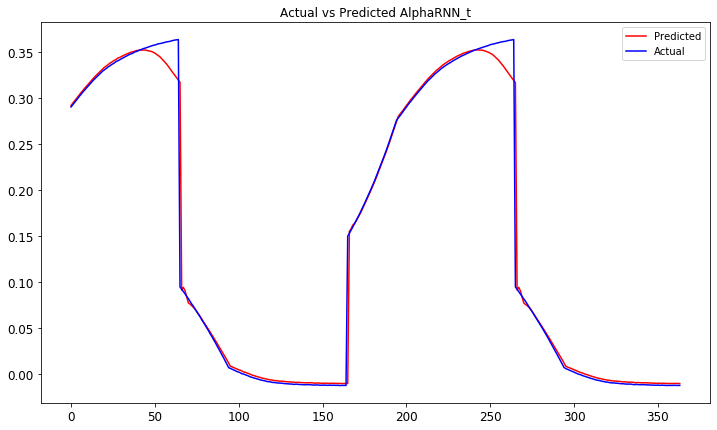

In [67]:
fig = plt.figure(figsize=(12,7))
plt.plot(alpharnnt_pred_test, color='r', label='Predicted')
plt.plot(y_test_reg.flatten(),'b', label='Actual')
plt.legend(loc=0)
plt.title('Actual vs Predicted AlphaRNN_t')
plt.show()

In [0]:
mse = mean_squared_error(y_test_reg[:,0],y_predicted_ar_t)
print(mse)

0.0004427545573362202


In [0]:
mse_std = np.math.sqrt(mse)
print(mse_std)

0.022216155077072364


In [0]:
y_predicted = session.run(model.output, feed_dict={model.input_layer: x_test_reg})
y_predicted_ar=np.array([0]*y_predicted.shape[0], dtype='float64')
for i in range(y_predicted.shape[0]):
     y_predicted_ar[i]=y_predicted[i][n_steps-1][0]

In [0]:
y_predicted = session.run(model.output, feed_dict={model.input_layer: x_train_reg})
y_predicted_train=np.array([0]*y_predicted.shape[0], dtype='float64')
for i in range(y_predicted.shape[0]):
     y_predicted_train[i]=y_predicted[i][n_steps-1][0]

In [0]:

se = mean_squared_error(y_test_reg[:,0],y_predicted_ar)
print(mse)
mse_std = np.math.sqrt(mse)
print(mse_std)

0.00042334075261903065
0.02057524611320678


#Comparison with Keras models


In [0]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM, GRU, SimpleRNN
from keras import optimizers
from keras.callbacks import EarlyStopping

In [0]:
x_train_reg = pd.concat(x_train_list, axis=1)
x_train_reg = x_train_reg.iloc[:, col_ords]
y_train_reg = df_train.loc[x_train_reg.index, [target]].values
x_train_reg = np.reshape(x_train_reg.values, (x_train_reg.shape[0], np.int(x_train_reg.shape[1] / len(use_features)), len(use_features)))

In [0]:
x_test_reg = pd.concat(x_test_list, axis=1)
x_test_reg = x_test_reg.iloc[:, col_ords]
y_test_reg = df_test.loc[x_test_reg.index, [target]].values
x_test_reg = np.reshape(x_test_reg.values, (x_test_reg.shape[0], np.int(x_test_reg.shape[1]/len(use_features)), len(use_features)))

In [0]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5, min_delta=1e-3)

In [0]:
def RNN_model2(n_units=10, l1_reg=0):
    reg_model = Sequential()
    reg_model.add(SimpleRNN(n_units, activation='tanh', input_shape=(x_train_reg.shape[1], x_train_reg.shape[-1]), unroll=True))
    reg_model.add(Dense(1, kernel_initializer='normal', kernel_regularizer=l1(l1_reg)))
    #reg_model.add(Dropout(0.2))
    reg_model.compile(loss='mean_squared_error', optimizer='adam')
    return reg_model

def GRU_model2(n_units = 10, l1_reg=0):
    reg_model = Sequential()
    reg_model.add(GRU(n_units, activation='tanh', input_shape=(x_train_reg.shape[1], x_train_reg.shape[-1]), unroll=True))
    reg_model.add(Dense(1, kernel_initializer='normal', kernel_regularizer=l1(l1_reg)))
    #reg_model.add(Dropout(0.2))
    reg_model.compile(loss='mean_squared_error', optimizer='adam')
    return reg_model

def LSTM_model2(n_units = 10, l1_reg=0):
    reg_model = Sequential()
    reg_model.add(LSTM(n_units, activation='tanh', input_shape=(x_train_reg.shape[1], x_train_reg.shape[-1]), unroll=True))
    #LPNorm.build_loss(p = float('inf'))
    reg_model.add(Dense(1, kernel_initializer='normal', kernel_regularizer=l1(l1_reg)))
    #reg_model.add(Dropout(0.2))
    reg_model.compile(loss='mean_squared_error', optimizer='adam')
    return reg_model

def AlphaRNN(hidden_units = 10, l1_reg=0):
  reg_model = Sequential()
  #reg_model.add(AlphaRNN(hidden_units, activation='tanh', recurrent_activation='sigmoid', input_shape=(x_train_reg.shape[1], x_train_reg.shape[-1]), unroll=True))
  reg_model.add(AlphatRNN(hidden_units, activation='tanh', recurrent_activation='sigmoid', input_shape=(x_train_reg.shape[1], x_train_reg.shape[-1]), unroll=True))
  #reg_model.add(GRU(hidden_units, activation='tanh', recurrent_activation='sigmoid', input_shape=(x_train_reg.shape[1], x_train_reg.shape[-1]), unroll=True))
  reg_model.add(Dense(1, kernel_initializer='normal', kernel_regularizer=l1(l1_reg)))
  #reg_model.add(Dropout(0.2))
  reg_model.compile(loss='mean_squared_error', optimizer='adam')
  reg_model.fit(x_train_reg,y_train_reg,epochs=2000, batch_size=500,callbacks=[es])
  return reg_model

In [95]:
n_units = [5,10,20]
l1_reg = [0]  #[0, 0.001]   #0.01, 0.1]
#param_grid = dict(epochs=epochs,batch_size =batch_size)
                  #n_neurons=n_neurons)
                  #optimizers=optimizers,
                  #n_neurons = n_neurons)
#learn_rate = [0.001, 0.01, 0.1, 0.2, 0.3]
#momentum = [0.0, 0.2, 0.4, 0.6, 0.8, 0.9]
#weight_constraint = [1, 2, 3, 4, 5]
#dropout_rate = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
tscv = TimeSeriesSplit(n_splits = 5)
param_grid = dict(n_units=n_units,l1_reg=l1_reg) 
#X_train, X_test, y_train, y_test = train_test_split(x_train_reg, y_train_reg, test_size=0.5, random_state=0) 
print("Hyper parameter tuning for RNN...")
model = KerasRegressor(build_fn=RNN_model2, epochs=2000, batch_size=100, verbose=2)
grid = GridSearchCV(estimator=model,param_grid=param_grid, cv=tscv, n_jobs=-1, verbose=2)
grid_result = grid.fit(x_train_reg,y_train_reg,callbacks=[es])
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
        print("%f (%f) with %r" % (mean, stdev, param))
# Manual CV
nodes_rnn = grid_result.best_params_['n_units']
l1_reg = grid_result.best_params_['l1_reg']
#n_units = [10, 20, 30, 40, 50, 60, 100]

Hyper parameter tuning for RNN...
Fitting 5 folds for each of 3 candidates, totalling 15 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


KeyboardInterrupt: ignored

In [94]:
rnn_model = RNN_model2(5,0)
rnn_fit = rnn_model.fit(x_train_reg,y_train_reg, epochs = 2000, batch_size=100, callbacks=[es])
#rnn_fit = rnn_model.fit(x_test_reg,y_test_reg, epochs=2000, batch_size=100, callbacks=[es])
rnn_pred_test = rnn_model.predict(x_test_reg,verbose=1)
mse = mean_squared_error(y_test_reg[:,0],rnn_pred_test[:,0])
print("RNN test data mse = " + str(mse))
print("RNN test std mse = " + str(np.sqrt(mse)))
rnn_model.summary()

Epoch 1/2000
1546/1546 [==============================] - 5s 3ms/step - loss: 0.0240
Epoch 2/2000
1546/1546 [==============================] - 0s 26us/step - loss: 0.0146
Epoch 3/2000
1546/1546 [==============================] - 0s 28us/step - loss: 0.0094
Epoch 4/2000
1546/1546 [==============================] - 0s 27us/step - loss: 0.0062
Epoch 5/2000
1546/1546 [==============================] - 0s 25us/step - loss: 0.0043
Epoch 6/2000
 100/1546 [>.............................] - ETA: 0s - loss: 0.0035

/usr/local/lib/python3.6/dist-packages/keras/callbacks.py:842: RuntimeWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss
  (self.monitor, ','.join(list(logs.keys()))), RuntimeWarning


1546/1546 [==============================] - 0s 30us/step - loss: 0.0031
Epoch 7/2000
1546/1546 [==============================] - 0s 29us/step - loss: 0.0023
Epoch 8/2000
1546/1546 [==============================] - 0s 26us/step - loss: 0.0019
Epoch 9/2000
1546/1546 [==============================] - 0s 28us/step - loss: 0.0017
Epoch 10/2000
1546/1546 [==============================] - 0s 30us/step - loss: 0.0016
Epoch 11/2000
1546/1546 [==============================] - 0s 27us/step - loss: 0.0015
Epoch 12/2000
1546/1546 [==============================] - 0s 28us/step - loss: 0.0014
Epoch 13/2000
1546/1546 [==============================] - 0s 27us/step - loss: 0.0014
Epoch 14/2000
1546/1546 [==============================] - 0s 26us/step - loss: 0.0013
Epoch 15/2000
1546/1546 [==============================] - 0s 25us/step - loss: 0.0013
Epoch 16/2000
1546/1546 [==============================] - 0s 25us/step - loss: 0.0013
Epoch 17/2000
1546/1546 [==============================] - 0

In [56]:
# make predictions with the trained RNN
rnn_pred_train = rnn_model.predict(x_train_reg, verbose=1)
rnn_pred_test = rnn_model.predict(x_test_reg, verbose=1)

364/364 [==============================] - 0s 32us/step


In [0]:
# calculate mean squared error of the plain RNN
MSE_train = mean_squared_error(df_train[use_feature][n_steps:], rnn_pred_train[:, 0])
print(MSE_train)
MSE_test = mean_squared_error(df_test[use_feature][n_steps:], rnn_pred_test[:, 0])
print(MSE_test)
MSE_train_std = np.sqrt(MSE_train)
print(MSE_train_std)
MSE_test_std = np.sqrt(M

In [0]:
model = KerasRegressor(build_fn=LSTM_model2, epochs=2000, batch_size=100, verbose=2)
grid = GridSearchCV(estimator=model,param_grid=param_grid, cv=tscv, n_jobs=-1, verbose=2)
grid_result = grid.fit(x_train_reg,y_train_reg,callbacks=[es])
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
        print("%f (%f) with %r" % (mean, stdev, param))
# Manual CV
nodes_lstm = grid_result.best_params_['n_units']
l1_reg = grid_result.best_params_['l1_reg']

Fitting 5 folds for each of 5 candidates, totalling 25 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
/usr/local/lib/python3.6/dist-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
[Parallel(n_jobs=-1)]: Done  25 out of  25 | elapsed: 52.5min finished


Epoch 1/2000
 - 7s - loss: 0.0409
Epoch 2/2000
 - 0s - loss: 0.0329
Epoch 3/2000


/usr/local/lib/python3.6/dist-packages/keras/callbacks.py:842: RuntimeWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss
  (self.monitor, ','.join(list(logs.keys()))), RuntimeWarning


 - 0s - loss: 0.0260
Epoch 4/2000
 - 0s - loss: 0.0201
Epoch 5/2000
 - 0s - loss: 0.0157
Epoch 6/2000
 - 0s - loss: 0.0123
Epoch 7/2000
 - 0s - loss: 0.0088
Epoch 8/2000
 - 0s - loss: 0.0052
Epoch 9/2000
 - 0s - loss: 0.0036
Epoch 10/2000
 - 0s - loss: 0.0034
Epoch 11/2000
 - 0s - loss: 0.0033
Epoch 12/2000
 - 0s - loss: 0.0032
Epoch 13/2000
 - 0s - loss: 0.0031
Epoch 14/2000
 - 0s - loss: 0.0030
Epoch 15/2000
 - 0s - loss: 0.0029
Epoch 16/2000
 - 0s - loss: 0.0028
Epoch 17/2000
 - 0s - loss: 0.0027
Epoch 18/2000
 - 0s - loss: 0.0026
Epoch 19/2000
 - 0s - loss: 0.0025
Epoch 20/2000
 - 0s - loss: 0.0024
Epoch 21/2000
 - 0s - loss: 0.0023
Epoch 22/2000
 - 0s - loss: 0.0022
Epoch 23/2000
 - 0s - loss: 0.0021
Epoch 24/2000
 - 0s - loss: 0.0021
Epoch 25/2000
 - 0s - loss: 0.0020
Epoch 26/2000
 - 0s - loss: 0.0019
Epoch 27/2000
 - 0s - loss: 0.0019
Epoch 28/2000
 - 0s - loss: 0.0018
Epoch 29/2000
 - 0s - loss: 0.0017
Epoch 30/2000
 - 0s - loss: 0.0017
Epoch 31/2000
 - 0s - loss: 0.0016
Epoch

In [61]:
lstm_model = LSTM_model2(5,0)
lstm_fit = lstm_model.fit(x_train_reg,y_train_reg, epochs=2000, batch_size=100, callbacks=[es])
lstm_pred_test = lstm_model.predict(x_test_reg,verbose=1)
mse = mean_squared_error(y_test_reg[:,0],lstm_pred_test[:,0])
print("LSTM test data mse = " + str(mse))
print("LSTM test std mse =  " + str(np.math.sqrt(mse)))
#score = cross_val_score(y_test_reg[:,0],g
lstm_model.summary()




Epoch 1/2000
1546/1546 [==============================] - 8s 5ms/step - loss: 0.0376
Epoch 2/2000
1546/1546 [==============================] - 0s 109us/step - loss: 0.0296
Epoch 3/2000
 100/1546 [>.............................] - ETA: 0s - loss: 0.0305

/usr/local/lib/python3.6/dist-packages/keras/callbacks.py:842: RuntimeWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss
  (self.monitor, ','.join(list(logs.keys()))), RuntimeWarning


1546/1546 [==============================] - 0s 130us/step - loss: 0.0218
Epoch 4/2000
1546/1546 [==============================] - 0s 131us/step - loss: 0.0157
Epoch 5/2000
1546/1546 [==============================] - 0s 123us/step - loss: 0.0125
Epoch 6/2000
1546/1546 [==============================] - 0s 129us/step - loss: 0.0095
Epoch 7/2000
1546/1546 [==============================] - 0s 135us/step - loss: 0.0066
Epoch 8/2000
1546/1546 [==============================] - 0s 128us/step - loss: 0.0048
Epoch 9/2000
1546/1546 [==============================] - 0s 128us/step - loss: 0.0041
Epoch 10/2000
1546/1546 [==============================] - 0s 154us/step - loss: 0.0038
Epoch 11/2000
1546/1546 [==============================] - 0s 129us/step - loss: 0.0036
Epoch 12/2000
1546/1546 [==============================] - 0s 132us/step - loss: 0.0033
Epoch 13/2000
1546/1546 [==============================] - 0s 142us/step - loss: 0.0031
Epoch 14/2000
1546/1546 [===========================

In [0]:
lstm_pred_test = lstm_model.predict(x_test_reg,verbose=1)
mse = mean_squared_error(y_test_reg[:,0],lstm_pred_test[:,0])
print("LSTM test data mse = " + str(mse))
print("LSTM test std mse =  " + str(np.math.sqrt(mse)))
#score = cross_val_score(y_test_reg[:,0],g
lstm_model.summary()

In [0]:
# make predictions with the trained LSTM
lstm_pred_train = lstm_model.predict(x_train_reg, verbose=1)
lstm_pred_test = lstm_model.predict(x_test_reg, verbose=1)

In [0]:
# calculate mean squared error of the GRU
MSE_train = mean_squared_error(df_train[use_feature][n_steps:], lstm_pred_train[:, 0])
print(MSE_train)
MSE_test = mean_squared_error(df_test[use_feature][n_steps:],lstm_pred_test[:, 0])
print(MSE_test)
MSE_train_std = np.sqrt(MSE_train)
print(MSE_train_std)
MSE_test_std = np.sqrt(MSE_test)
print(MSE_test_std)

In [0]:
print("Hyper parameter tuning of GRU model")
model = KerasRegressor(build_fn=GRU_model2, epochs=2000, batch_size=500, verbose=2)
grid = GridSearchCV(estimator=model,param_grid=param_grid, cv=tscv, n_jobs=-1, verbose=2)
grid_result = grid.fit(x_train_reg,y_train_reg,callbacks=[es])
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
        print("%f (%f) with %r" % (mean, stdev, param))
# Manual CV
nodes_gru = grid_result.best_params_['n_units']
l1_reg = grid_result.best_params_['l1_reg']

Hyper parameter tuning of GRU model
Fitting 5 folds for each of 5 candidates, totalling 25 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
/usr/local/lib/python3.6/dist-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
[Parallel(n_jobs=-1)]: Done  25 out of  25 | elapsed: 17.4min finished


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Epoch 1/2000
 - 4s - loss: 0.0394
Epoch 2/2000
 - 0s - loss: 0.0369
Epoch 3/2000
 - 0s - loss: 0.0343
Epoch 4/2000
 - 0s - loss: 0.0319
Epoch 5/2000
 - 0s - loss: 0.0294
Epoch 6/2000


/usr/local/lib/python3.6/dist-packages/keras/callbacks.py:842: RuntimeWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss
  (self.monitor, ','.join(list(logs.keys()))), RuntimeWarning


 - 0s - loss: 0.0270
Epoch 7/2000
 - 0s - loss: 0.0246
Epoch 8/2000
 - 0s - loss: 0.0223
Epoch 9/2000
 - 0s - loss: 0.0201
Epoch 10/2000
 - 0s - loss: 0.0180
Epoch 11/2000
 - 0s - loss: 0.0160
Epoch 12/2000
 - 0s - loss: 0.0142
Epoch 13/2000
 - 0s - loss: 0.0127
Epoch 14/2000
 - 0s - loss: 0.0114
Epoch 15/2000
 - 0s - loss: 0.0105
Epoch 16/2000
 - 0s - loss: 0.0099
Epoch 17/2000
 - 0s - loss: 0.0094
Epoch 18/2000
 - 0s - loss: 0.0089
Epoch 19/2000
 - 0s - loss: 0.0085
Epoch 20/2000
 - 0s - loss: 0.0079
Epoch 21/2000
 - 0s - loss: 0.0073
Epoch 22/2000
 - 0s - loss: 0.0066
Epoch 23/2000
 - 0s - loss: 0.0060
Epoch 24/2000
 - 0s - loss: 0.0054
Epoch 25/2000
 - 0s - loss: 0.0047
Epoch 26/2000
 - 0s - loss: 0.0041
Epoch 27/2000
 - 0s - loss: 0.0035
Epoch 28/2000
 - 0s - loss: 0.0029
Epoch 29/2000
 - 0s - loss: 0.0025
Epoch 30/2000
 - 0s - loss: 0.0021
Epoch 31/2000
 - 0s - loss: 0.0019
Epoch 32/2000
 - 0s - loss: 0.0017
Epoch 33/2000
 - 0s - loss: 0.0016
Epoch 34/2000
 - 0s - loss: 0.0016
Ep

In [58]:
gru_model = GRU_model2(5,0)
gru_fit = gru_model.fit(x_train_reg,y_train_reg, epochs=2000, batch_size=100, callbacks=[es])
gru_pred_test = gru_model.predict(x_test_reg,verbose=1)
mse = mean_squared_error(y_test_reg[:,0],gru_pred_test[:,0])
print("GRU test data mse = " + str(mse))
print("GRU test std mse =  " + str(np.math.sqrt(mse)))
gru_model.summary()

Epoch 1/2000
1546/1546 [==============================] - 6s 4ms/step - loss: 0.0417
Epoch 2/2000
1546/1546 [==============================] - 0s 96us/step - loss: 0.0350
Epoch 3/2000
 100/1546 [>.............................] - ETA: 0s - loss: 0.0337

/usr/local/lib/python3.6/dist-packages/keras/callbacks.py:842: RuntimeWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss
  (self.monitor, ','.join(list(logs.keys()))), RuntimeWarning


1546/1546 [==============================] - 0s 100us/step - loss: 0.0292
Epoch 4/2000
1546/1546 [==============================] - 0s 103us/step - loss: 0.0238
Epoch 5/2000
1546/1546 [==============================] - 0s 97us/step - loss: 0.0185
Epoch 6/2000
1546/1546 [==============================] - 0s 101us/step - loss: 0.0145
Epoch 7/2000
1546/1546 [==============================] - 0s 102us/step - loss: 0.0123
Epoch 8/2000
1546/1546 [==============================] - 0s 112us/step - loss: 0.0098
Epoch 9/2000
1546/1546 [==============================] - 0s 104us/step - loss: 0.0067
Epoch 10/2000
1546/1546 [==============================] - 0s 102us/step - loss: 0.0040
Epoch 11/2000
1546/1546 [==============================] - 0s 103us/step - loss: 0.0028
Epoch 12/2000
1546/1546 [==============================] - 0s 110us/step - loss: 0.0026
Epoch 13/2000
1546/1546 [==============================] - 0s 98us/step - loss: 0.0024
Epoch 14/2000
1546/1546 [=============================

In [0]:
# MFD: Also try GRU, SimpleRNN
# Need to cross-validate for the best number of hidden units (i.e. hidden_size)
#gru_model = Sequential()
#gru_model.add(GRU(hidden_size, input_shape=(x_train_reg.shape[1], x_train_reg.shape[-1])))
#gru_model.add(Dense(1))
#gru_model.compile(loss='mean_squared_error', optimizer='adam')

#gru_model.fit(x_train_reg, y_train_reg, epochs=2000, batch_size=100, callbacks=[es])

In [0]:
#gru_fit = gru_model.fit(x_test_reg,y_test_reg, epochs=2000, batch_size=100, callbacks=[es])
gru_pred_test = gru_model.predict(x_test_reg,verbose=1)
mse = mean_squared_error(y_test_reg[:,0],gru_pred_test[:,0])
print("GRU test data mse = " + str(mse))
print("GRU test std mse =  " + str(np.math.sqrt(mse)))
gru_model.summary()

374/374 [==============================] - 0s 99us/step
GRU test data mse = 0.00038023759714453945
GRU test std mse =  0.01949968197547179
Model: "sequential_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_2 (GRU)                  (None, 5)                 105       
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 6         
Total params: 111
Trainable params: 111
Non-trainable params: 0
_________________________________________________________________


In [59]:
gru_pred_train = gru_model.predict(x_train_reg, verbose=1)
gru_pred_test = gru_model.predict(x_test_reg, verbose=1)

364/364 [==============================] - 0s 65us/step


In [42]:
# calculate mean squared error of the GRU
MSE_train = mean_squared_error(df_train[use_feature][n_steps:], gru_pred_train[:, 0])
print(MSE_train)
MSE_test = mean_squared_error(df_test[use_feature][n_steps:], gru_pred_test[:, 0])
print(MSE_test)
MSE_train_std = np.sqrt(MSE_train)
print(MSE_train_std)
MSE_test_std = np.sqrt(MSE_test)
print(MSE_test_std)

0.0005033678075954493
0.0004647013408848037
0.022435859858615834
0.02155693254813411


In [0]:


hidden_size = 5
rnn_model = Sequential()
rnn_model.add(SimpleRNN(hidden_size, input_shape=(x_train_reg.shape[1], x_train_reg.shape[-1])))
rnn_model.add(Dense(1))
rnn_model.compile(loss='mean_squared_error', optimizer='adam')

rnn_model.fit(x_train_reg, y_train_reg, epochs=2000, batch_size=100, callbacks=[es])

Epoch 1/2000
1556/1556 [==============================] - 3s 2ms/step - loss: 0.0653
Epoch 2/2000
1556/1556 [==============================] - 0s 45us/step - loss: 0.0301
Epoch 3/2000
1556/1556 [==============================] - 0s 37us/step - loss: 0.0225
Epoch 4/2000
1300/1556 [========================>.....] - ETA: 0s - loss: 0.0209

/usr/local/lib/python3.6/dist-packages/keras/callbacks.py:842: RuntimeWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss
  (self.monitor, ','.join(list(logs.keys()))), RuntimeWarning


1556/1556 [==============================] - 0s 49us/step - loss: 0.0206
Epoch 5/2000
1556/1556 [==============================] - 0s 38us/step - loss: 0.0190
Epoch 6/2000
1556/1556 [==============================] - 0s 45us/step - loss: 0.0178
Epoch 7/2000
1556/1556 [==============================] - 0s 46us/step - loss: 0.0166
Epoch 8/2000
1556/1556 [==============================] - 0s 46us/step - loss: 0.0156
Epoch 9/2000
1556/1556 [==============================] - 0s 49us/step - loss: 0.0146
Epoch 10/2000
1556/1556 [==============================] - 0s 49us/step - loss: 0.0138
Epoch 11/2000
1556/1556 [==============================] - 0s 48us/step - loss: 0.0129
Epoch 12/2000
1556/1556 [==============================] - 0s 42us/step - loss: 0.0122
Epoch 13/2000
1556/1556 [==============================] - 0s 41us/step - loss: 0.0115
Epoch 14/2000
1556/1556 [==============================] - 0s 47us/step - loss: 0.0109
Epoch 15/2000
1556/1556 [==============================] - 0s 

In [0]:
rnn_model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn_2 (SimpleRNN)     (None, 5)                 35        
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 6         
Total params: 41
Trainable params: 41
Non-trainable params: 0
_________________________________________________________________


In [0]:
hidden_size = 5
lstm_model = Sequential()
lstm_model.add(LSTM(hidden_size, input_shape=(x_train_reg.shape[1], x_train_reg.shape[-1])))
lstm_model.add(Dense(1))
lstm_model.compile(loss='mean_squared_error', optimizer='adam')
lstm_model.fit(x_train_reg, y_train_reg, epochs=2000, batch_size=100, callbacks=[es])

Epoch 1/2000
1556/1556 [==============================] - 4s 3ms/step - loss: 0.0352
Epoch 2/2000
1200/1556 [======================>.......] - ETA: 0s - loss: 0.0210

/usr/local/lib/python3.6/dist-packages/keras/callbacks.py:842: RuntimeWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss
  (self.monitor, ','.join(list(logs.keys()))), RuntimeWarning


1556/1556 [==============================] - 0s 173us/step - loss: 0.0201
Epoch 3/2000
1556/1556 [==============================] - 0s 178us/step - loss: 0.0129
Epoch 4/2000
1556/1556 [==============================] - 0s 179us/step - loss: 0.0102
Epoch 5/2000
1556/1556 [==============================] - 0s 172us/step - loss: 0.0083
Epoch 6/2000
1556/1556 [==============================] - 0s 175us/step - loss: 0.0064
Epoch 7/2000
1556/1556 [==============================] - 0s 178us/step - loss: 0.0046
Epoch 8/2000
1556/1556 [==============================] - 0s 163us/step - loss: 0.0033
Epoch 9/2000
1556/1556 [==============================] - 0s 162us/step - loss: 0.0026
Epoch 10/2000
1556/1556 [==============================] - 0s 167us/step - loss: 0.0024
Epoch 11/2000
1556/1556 [==============================] - 0s 163us/step - loss: 0.0023
Epoch 12/2000
1556/1556 [==============================] - 0s 161us/step - loss: 0.0022
Epoch 13/2000
1556/1556 [============================

In [62]:
lstm_pred_test = lstm_model.predict(x_test_reg,verbose=1)
mse = mean_squared_error(y_test_reg[:,0],lstm_pred_test[:,0])
print("LSTM test data mse = " + str(mse))
print("LSTM test std mse = " + str(np.sqrt(mse)))

364/364 [==============================] - 0s 106us/step
LSTM test data mse = 0.0004083235162005724
LSTM test std mse = 0.020207016509137917


In [0]:
lstm_model.summary()

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 5)                 140       
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 6         
Total params: 146
Trainable params: 146
Non-trainable params: 0
_________________________________________________________________


In [44]:
# make predictions with the trained LSTM
lstm_pred_train = lstm_model.predict(x_train_reg, verbose=1)
lstm_pred_test = lstm_model.predict(x_test_reg, verbose=1)

364/364 [==============================] - 0s 68us/step


In [38]:
# make predictions with the trained RNN
rnn_pred_train = rnn_model.predict(x_train_reg, verbose=1)
rnn_pred_test = rnn_model.predict(x_test_reg, verbose=1)

364/364 [==============================] - 0s 37us/step


In [0]:
gru_pred_train = gru_model.predict(x_train_reg, verbose=1)
gru_pred_test = gru_model.predict(x_test_reg, verbose=1)

374/374 [==============================] - 0s 63us/step


In [48]:
alpharnnt_pred_train = alpharnnt.predict(x_train_reg, verbose=1)
alpharnnt_pred_test = alpharnnt.predict(x_test_reg, verbose=1)

NameError: ignored

In [0]:
alpharnn_pred_train = alpharnn.predict(x_train_reg, verbose=1)
alpharnn_pred_test = alpharnn.predict(x_test_reg, verbose=1)

374/374 [==============================] - 0s 42us/step


In [77]:
alpharnnt_pred_train = reg_model.predict(x_train_reg, verbose=1)
alpharnnt_pred_test = reg_model.predict(x_test_reg, verbose=1)
 

364/364 [==============================] - 0s 57us/step


In [27]:
alpharnn_pred_train = reg_model2.predict(x_train_reg, verbose=1)
alpharnn_pred_test = reg_model2.predict(x_test_reg, verbose=1)

364/364 [==============================] - 0s 40us/step


In [57]:
# calculate mean squared error of the plain RNN
MSE_train = mean_squared_error(df_train[use_feature][n_steps:], rnn_pred_train[:, 0])
print(MSE_train)
MSE_test = mean_squared_error(df_test[use_feature][n_steps:], rnn_pred_test[:, 0])
print(MSE_test)
MSE_train_std = np.sqrt(MSE_train)
print(MSE_train_std)
MSE_test_std = np.sqrt(MSE_test)
print(MSE_test_std)

0.0004948164894755528
0.0004582636251681164
0.02224447098664189
0.021407092870544483


In [60]:
# calculate mean squared error of the GRU
MSE_train = mean_squared_error(df_train[use_feature][n_steps:], gru_pred_train[:, 0])
print(MSE_train)
MSE_test = mean_squared_error(df_test[use_feature][n_steps:], gru_pred_test[:, 0])
print(MSE_test)
MSE_train_std = np.sqrt(MSE_train)
print(MSE_train_std)
MSE_test_std = np.sqrt(MSE_test)
print(MSE_test_std)

0.00048573946117839507
0.00044859007702669705
0.02203949775240795
0.021179945161088048


In [64]:
# calculate mean squared error of the GRU
MSE_train = mean_squared_error(df_train[use_feature][n_steps:], lstm_pred_train[:, 0])
print(MSE_train)
MSE_test = mean_squared_error(df_test[use_feature][n_steps:],lstm_pred_test[:, 0])
print(MSE_test)
MSE_train_std = np.sqrt(MSE_train)
print(MSE_train_std)
MSE_test_std = np.sqrt(MSE_test)
print(MSE_test_std)

0.000503095721035478
0.0004083235162005724
0.022429795385501803
0.020207016509137917


In [79]:
# calculate mean squared error of the alpha RNN

MSE_train = mean_squared_error(df_train[use_feature][n_steps:], alpharnnt_pred_train)  #train_losses[:, 0])
print(MSE_train)
MSE_test = mean_squared_error(df_test[use_feature][n_steps:], alpharnnt_pred_test)     #validation_losses[:, 0])
print(MSE_test)
MSE_train_sd = np.sqrt(MSE_train)
print(MSE_train_sd)
MSE_test_sd = np.sqrt(MSE_test)
print(MSE_test_sd)

0.0004944182975087837
0.0004544248130152142
0.02223551882706549
0.02131724215313074


In [28]:

MSE_train = mean_squared_error(df_train[use_feature][n_steps:], alpharnn_pred_train)  #train_losses[:, 0])
print(MSE_train)
MSE_test = mean_squared_error(df_test[use_feature][n_steps:], alpharnn_pred_test)     #validation_losses[:, 0])
print(MSE_test)
MSE_train_sd = np.sqrt(MSE_train)
print(MSE_train_sd)
MSE_test_sd = np.sqrt(MSE_test)
print(MSE_test_sd)


0.0004926289741805186
0.0004538348274091063
0.022195246657348025
0.021303399433168085


In [0]:
# calculate mean squared error of the alpha RNN

#MSE_train = mean_squared_error(df_train[use_feature][n_steps:], y_predicted_train_t)  #train_losses[:, 0])
#print(MSE_train)
#MSE_test = mean_squared_error(df_test[use_feature][n_steps:], y_predicted_ar_t)     #validation_losses[:, 0])
#print(MSE_test)
MSE_train_sd = np.sqrt(MSE_train)
print(MSE_train_sd)
MSE_test_sd = np.sqrt(MSE_test)
print(MSE_test_sd)

NameError: ignored

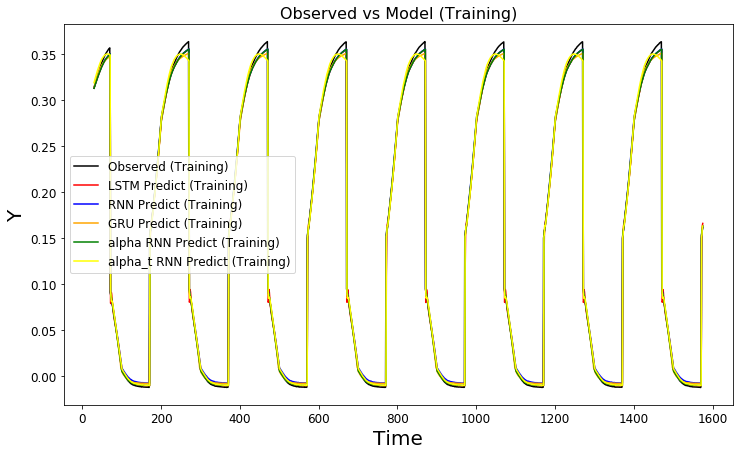

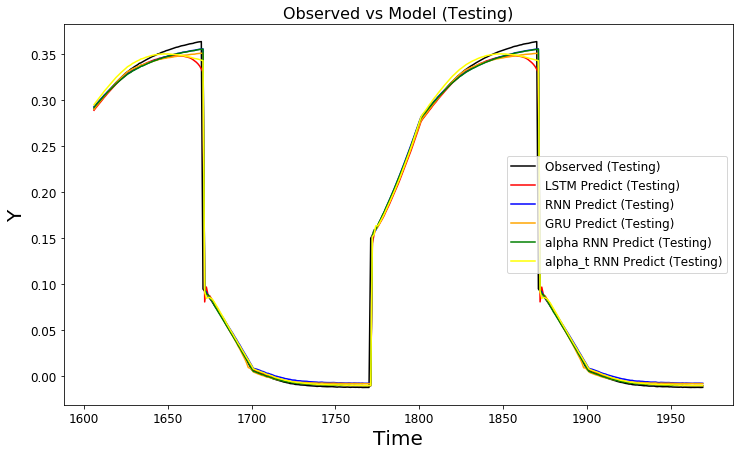

In [70]:
fig = plt.figure(figsize=(12,7))
train_line_real = plt.plot(df_train.index[n_steps:], df_train[use_feature][n_steps:], color="black", label="Observed (Training)")
train_line_pred = plt.plot(df_train.index[n_steps:], lstm_pred_train[:, 0], color="red", label="LSTM Predict (Training)")
train_line_pred = plt.plot(df_train.index[n_steps:], rnn_pred_train[:, 0], color="blue", label="RNN Predict (Training)")
train_line_pred = plt.plot(df_train.index[n_steps:], gru_pred_train[:, 0], color="orange", label="GRU Predict (Training)")
train_line_pred = plt.plot(df_train.index[n_steps:], alpharnn_pred_train[:,0], color='green', label="alpha RNN Predict (Training)")
train_line_pred = plt.plot(df_train.index[n_steps:], alpharnnt_pred_train[:,0], color="yellow", label="alpha_t RNN Predict (Training)" )

plt.legend(loc="best", fontsize=12)
plt.title('Observed vs Model (Training)', fontsize=16)
plt.xlabel('Time', fontsize=20)
plt.ylabel('Y', fontsize=20)

fig = plt.figure(figsize=(12,7))
test_line_real = plt.plot(df_test.index[n_steps:], df_test[use_feature][n_steps:], color="black", label="Observed (Testing)")
test_line_pred = plt.plot(df_test.index[n_steps:], lstm_pred_test[:, 0], color="red", label="LSTM Predict (Testing)")
test_line_pred = plt.plot(df_test.index[n_steps:], rnn_pred_test[:, 0], color="blue", label="RNN Predict (Testing)")
test_line_pred = plt.plot(df_test.index[n_steps:], gru_pred_test[:, 0], color="orange", label="GRU Predict (Testing)")
test_line_pred = plt.plot(df_test.index[n_steps:], alpharnn_pred_test,color="green", label="alpha RNN Predict (Testing)")
test_line_pred = plt.plot(df_test.index[n_steps:], alpharnnt_pred_test, color="yellow", label= "alpha_t RNN Predict (Testing)")
# train_line_pred = plt.plot(session.run(output, feed_dict={alpharnn.input_layer: x_test_reg})
plt.legend(loc="best", fontsize=12)
plt.title('Observed vs Model (Testing)', fontsize=16)
plt.xlabel('Time', fontsize=20)
plt.ylabel('Y', fontsize=20)

plt.show()